In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#@title Import Libraries
# imports
!pip install imagecodecs
import imagecodecs
import tensorflow as tf

import numpy as np

import tensorflow as tf

from typing import Callable, Union

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K

import time
import os
from skimage.io import imsave, imshow, imsave, imread

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, Permute

from tensorflow.keras.losses import binary_crossentropy


from tensorflow.keras import Model
from tensorflow.keras.activations import softmax
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import load_model
from keras.utils import  Sequence

     |████████████████████████████████| 24.7MB 164kB/s 


In [ ]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

mask_cls=4
img_cols = 900
img_rows = 900
batch_size = 2400#4800
smooth = 1.

target_width = 96 #128
target_height = 96 #128

seed = 123

In [ ]:
#@title Load Model
# load model
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def jaccard_distance(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    return (intersection + smooth) / (sum_ - intersection + smooth)

def jaccard_distance_loss(y_true, y_pred, smooth=2):
    jac = jaccard_distance(y_true, y_pred, smooth)
    return (1 - jac) * smooth

def dice_bce_connectivity_loss(y_true, y_pred, alpha = 0.1):
    #loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    loss = binary_crossentropy(y_true, y_pred) + (1*dice_loss(y_true, y_pred)) + alpha * K.sum(tf_diff_axis_0(y_true) - tf_diff_axis_0(y_pred))
    return loss

def dice_bce_loss(y_true, y_pred):
    #loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    loss = binary_crossentropy(y_true, y_pred) + (1*dice_loss(y_true, y_pred))
    return loss
def weighted_dice_coef(y_true, y_pred):
  #weighted DICE loss as per https://arxiv.org/abs/1707.03237
  #https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/37808
  mean = 0.2
  w_1 = 1/mean**2
  w_0 = 1/(1-mean)**2
  y_true_f_1 = K.flatten(y_true)
  y_pred_f_1 = K.flatten(y_pred)
  y_true_f_0 = K.flatten(1-y_true)
  y_pred_f_0 = K.flatten(1-y_pred)

  intersection_0 = K.sum(y_true_f_0 * y_pred_f_0)
  intersection_1 = K.sum(y_true_f_1 * y_pred_f_1)

  return 2 * (w_0 * intersection_0 + w_1 * intersection_1) / ((w_0 * (K.sum(y_true_f_0) + K.sum(y_pred_f_0))) + (w_1 * (K.sum(y_true_f_1) + K.sum(y_pred_f_1))))

def weighted_dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

model_dir = '/content/drive/My Drive/worm_models/fine-segmentation/models/final'

model_file = os.path.join(model_dir,'Jan-19-2021_22-47_unet_multihead_fg', 'model.h5')
#model_file = os.path.join(model_dir,'logs','dice_loss_Nov-28-2020_17-15', 'model.h5')
#model_file = os.path.join(model_dir,'logs','combo_loss_Nov-28-2020_18-15', 'model.h5')
model = load_model(model_file, custom_objects={'dice_bce_loss': dice_bce_loss, 'weighted_dice_coef' : weighted_dice_coef, 'weighted_dice_loss':weighted_dice_loss, 'dice_bce_connectivity_loss':dice_bce_connectivity_loss, 'dice_coeff': dice_coeff, 'dice_loss': dice_loss,'jaccard_distance': jaccard_distance})


(40, 96, 96, 1)


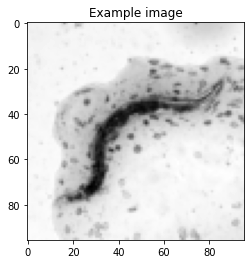

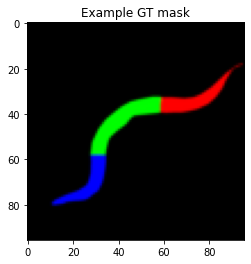

In [ ]:
#@title Load Segmentation Test Data
# load test data
test_img_dir = os.path.join('/content/drive/My Drive/worm_models/fine-segmentation/','test','img')

images = [f for f in os.listdir(test_img_dir) if f.endswith('.png')]

test_imgs = np.ndarray((len(images), img_rows, img_cols, 1), dtype=np.float)
test_masks = np.ndarray((len(images), img_rows, img_cols, 3), dtype=np.float)

for idx, img_name in enumerate(images):
        #print(idx)
        test_imgs[idx, :, :, 0] = imread(os.path.join(test_img_dir, img_name), as_gray=True)
        #img = np.expand_dims(img, axis=-1)

        #print(np.expand_dims(imread(os.path.join(test_img_dir, 'masks', 'tailMask', img_name), as_gray=True), axis=-1).shape)
        test_masks[idx, :, :, 0] = imread(os.path.join(test_img_dir, 'masks', 'tailMask', img_name), as_gray=True)
        test_masks[idx, :, :, 1] = imread(os.path.join(test_img_dir, 'masks', 'midMask', img_name), as_gray=True)
        test_masks[idx, :, :, 2] = imread(os.path.join(test_img_dir, 'masks', 'headMask', img_name), as_gray=True)


n_imgs = test_imgs.shape[0]
test_imgs = test_imgs / 255
test_imgs = resize(test_imgs, (n_imgs, target_width, target_height, 1))
print(test_imgs.shape)

test_masks = np.rint((test_masks)/255)
test_masks = 1-test_masks
test_masks = resize(test_masks, (n_imgs, target_width, target_height, 3))

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(test_imgs[12]), cmap='gray')

plt.figure()
plt.title('Example GT mask')
plt.imshow(np.squeeze(test_masks[12]))

In [ ]:
#@title multihead 4 output
# run inference and plot 3 head
def stack_masks(m0, m1, m2, m3):
    mask = m0
    mask = np.append(mask, m1, axis = 3)
    mask = np.append(mask, m2, axis = 3)
    mask = np.append(mask, m3, axis = 3)
    return mask

test_image_datagen = ImageDataGenerator(samplewise_center=True,
                                        samplewise_std_normalization=True,
                                        rotation_range=0,
                                        width_shift_range=0.0,
                                        height_shift_range=0.0,
                                        brightness_range=None,
                                        shear_range=0.0,
                                        zoom_range=0.0)
test_mask_datagen = ImageDataGenerator(samplewise_center=False,
                                       samplewise_std_normalization=False,
                                       rotation_range=0,
                                       width_shift_range=0.0,
                                       height_shift_range=0.0,
                                       brightness_range=None,
                                       shear_range=0.0,
                                       preprocessing_function=np.rint,
                                       zoom_range=0.0)

test_image_datagen.fit(test_imgs, augment=False, seed=seed)
test_image_generator = test_image_datagen.flow(test_imgs, batch_size=batch_size, seed=seed)
x = test_image_generator.next()

test_mask_datagen.fit(test_imgs, augment=False, seed=seed)
test_mask_generator = test_mask_datagen.flow(test_masks, batch_size=batch_size, seed=seed)
y = test_mask_generator.next()

pred0, pred1, pred2, pred3 = model.predict(x)
pred = stack_masks(pred0, pred1, pred2, pred3)

pred = np.rint(pred)

for i in range(0, pred.shape[0]):
  plt.figure()
  plt.title('Example pred')
  plt.imshow(np.squeeze(pred[i, :,:,1:4]))

  plt.figure()
  plt.title('Example image')
  plt.imshow(np.squeeze(x[i, :,:]), cmap='gray')

  plt.figure()
  plt.title('Example GT')
  plt.imshow(np.squeeze(y[i, :,:,0:3]))


Output hidden; open in https://colab.research.google.com to view.


    Movement Class Activation Masks are:    
 in 0.34273895741634075% cases looking at tail,
    
 in 0.3405035574876893% cases looking at mid body,
    
 in 0.31675748509596996% cases looking at head,
    


,tail_cams_pct,mid_cams_pct,head_cams_pct
0,0.341664,0.330269,0.328067
1,0.346242,0.322679,0.331079
2,0.337276,0.324506,0.338217
3,0.329425,0.335148,0.335428
4,0.329366,0.359458,0.311177


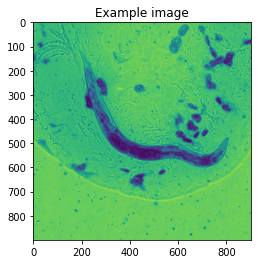

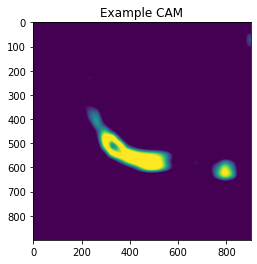

In [ ]:
#@title Load Low Movement Compute Overlap
# load measurements data
img_dir = os.path.join('/content/drive/My Drive/worm_models/movement/','test_images','3d','low')
pred_dir = os.path.join('/content/drive/My Drive/worm_models/movement/','test_images','3d','low_inference')
# load raw images
images = [f for f in os.listdir(img_dir) if f.endswith('.png')]



imgs = np.ndarray((len(images), img_rows, img_cols), dtype=np.float)
cams = np.ndarray((len(images), img_rows, img_cols), dtype=np.float)

for idx, img_name in enumerate(images):
        #print(idx)
        img = imread(os.path.join(img_dir, img_name), as_gray=True)
        #print(img.shape)
        #img = np.expand_dims(img, axis=-1)
        #print(img.shape)

        # load salincy plots
        cam = imread(os.path.join(pred_dir, img_name.replace('.png','_cam.tif')), as_gray=False, plugin='pil')
        cam = cam[:,:,2] # keep blue only - RGB [X,Y,Color]
        cam = np.rint(cam)
        #cam = np.expand_dims(cam, axis=-1)

        imgs[idx,:,:] = img.squeeze()
        cams[idx,:,:] = cam.squeeze()

imgs = np.expand_dims(imgs, axis=-1)
cams = np.expand_dims(cams, axis=-1)

n_imgs = test_imgs.shape[0]

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(imgs[80]))

plt.figure()
plt.title('Example CAM')
plt.imshow(np.squeeze(cams[80]))

small_imgs = resize(imgs, (n_imgs, target_width, target_height, 1))
small_cams = resize(cams, (n_imgs, target_width, target_height, 1))

test_image_datagen.fit(small_imgs, augment=False, seed=seed)
image_generator = test_image_datagen.flow(small_imgs, batch_size=n_imgs, seed=seed)


_bg_pred, tail_bg_pred , mid_bg_pred, head_bg_pred = model.predict(image_generator.next())

tail_cams = np.sum((1 - tail_bg_pred) * small_cams)
mid_cams = np.sum((1 - mid_bg_pred) * small_cams)
head_cams = np.sum((1 - head_bg_pred) * small_cams)

tail_cams_pct = tail_cams / (tail_cams + mid_cams + head_cams)
mid_cams_pct = mid_cams / (tail_cams + mid_cams + head_cams)
head_cams_pct = head_cams / (tail_cams + mid_cams + head_cams)
print(
    """
    Movement Class Activation Masks are:\
    \n in {}% cases looking at tail,
    \n in {}% cases looking at mid body,
    \n in {}% cases looking at head,
    """.format(tail_cams_pct, mid_cams_pct, head_cams_pct))

# Tally up for each image

tail_cams = np.sum((1 - tail_bg_pred) * small_cams, axis=(1,2,3))
mid_cams = np.sum((1 - mid_bg_pred) * small_cams, axis=(1,2,3))
head_cams = np.sum((1 - head_bg_pred) * small_cams, axis=(1,2,3))

tail_cams_pct = tail_cams / (tail_cams + mid_cams + head_cams)
mid_cams_pct = mid_cams / (tail_cams + mid_cams + head_cams)
head_cams_pct = head_cams / (tail_cams + mid_cams + head_cams)

import pandas as pd
results = pd.DataFrame({'tail_cams_pct':tail_cams_pct, 'mid_cams_pct':mid_cams_pct, 'head_cams_pct':head_cams_pct})

res_file = os.path.join('/content/drive/My Drive/worm_models/fine-segmentation/','Low_Movement_Overlap.csv')
results.to_csv(res_file)
results.head()


    Movement Class Activation Masks are:    
 in 0.3434654754221773% cases looking at tail,
    
 in 0.34565839439455465% cases looking at mid body,
    
 in 0.3108761301832681% cases looking at head,
    


,tail_cams_pct,mid_cams_pct,head_cams_pct
0,0.371932,0.327717,0.300351
1,0.435742,0.306872,0.257386
2,0.349393,0.333927,0.316681
3,0.330405,0.320307,0.349288
4,0.365704,0.369525,0.264772


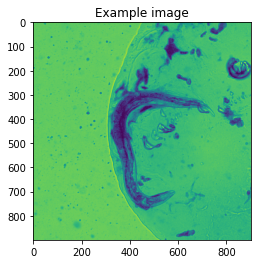

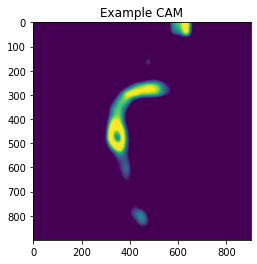

In [ ]:
#@title Load High Movement Compute Overlap
# load measurements data
img_dir = os.path.join('/content/drive/My Drive/worm_models/movement/','test_images','3d','high')
pred_dir = os.path.join('/content/drive/My Drive/worm_models/movement/','test_images','3d','high_inference')
# load raw images
images = [f for f in os.listdir(img_dir) if f.endswith('.png')]



imgs = np.ndarray((len(images), img_rows, img_cols), dtype=np.float)
cams = np.ndarray((len(images), img_rows, img_cols), dtype=np.float)

for idx, img_name in enumerate(images):
        #print(idx)
        img = imread(os.path.join(img_dir, img_name), as_gray=True)
        #print(img.shape)
        #img = np.expand_dims(img, axis=-1)
        #print(img.shape)

        # load salincy plots
        cam = imread(os.path.join(pred_dir, img_name.replace('.png','_cam.tif')), as_gray=False, plugin='pil')
        cam = cam[:,:,2] # keep blue only - RGB [X,Y,Color]
        cam = np.rint(cam)
        #cam = np.expand_dims(cam, axis=-1)

        imgs[idx,:,:] = img.squeeze()
        cams[idx,:,:] = cam.squeeze()

imgs = np.expand_dims(imgs, axis=-1)
cams = np.expand_dims(cams, axis=-1)

n_imgs = test_imgs.shape[0]

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(imgs[80]))

plt.figure()
plt.title('Example CAM')
plt.imshow(np.squeeze(cams[80]))

small_imgs = resize(imgs, (n_imgs, target_width, target_height, 1))
small_cams = resize(cams, (n_imgs, target_width, target_height, 1))

test_image_datagen.fit(small_imgs, augment=False, seed=seed)
image_generator = test_image_datagen.flow(small_imgs, batch_size=n_imgs, seed=seed)


_bg_pred, tail_bg_pred , mid_bg_pred, head_bg_pred = model.predict(image_generator.next())

tail_cams = np.sum((1 - tail_bg_pred) * small_cams)
mid_cams = np.sum((1 - mid_bg_pred) * small_cams)
head_cams = np.sum((1 - head_bg_pred) * small_cams)

tail_cams_pct = tail_cams / (tail_cams + mid_cams + head_cams)
mid_cams_pct = mid_cams / (tail_cams + mid_cams + head_cams)
head_cams_pct = head_cams / (tail_cams + mid_cams + head_cams)
print(
    """
    Movement Class Activation Masks are:\
    \n in {}% cases looking at tail,
    \n in {}% cases looking at mid body,
    \n in {}% cases looking at head,
    """.format(tail_cams_pct, mid_cams_pct, head_cams_pct))

# Tally up for each image

tail_cams = np.sum((1 - tail_bg_pred) * small_cams, axis=(1,2,3))
mid_cams = np.sum((1 - mid_bg_pred) * small_cams, axis=(1,2,3))
head_cams = np.sum((1 - head_bg_pred) * small_cams, axis=(1,2,3))

tail_cams_pct = tail_cams / (tail_cams + mid_cams + head_cams)
mid_cams_pct = mid_cams / (tail_cams + mid_cams + head_cams)
head_cams_pct = head_cams / (tail_cams + mid_cams + head_cams)

import pandas as pd
results = pd.DataFrame({'tail_cams_pct':tail_cams_pct, 'mid_cams_pct':mid_cams_pct, 'head_cams_pct':head_cams_pct})

res_file = os.path.join('/content/drive/My Drive/worm_models/fine-segmentation/','High_Movement_Overlap.csv')
results.to_csv(res_file)
results.head()


    Movement Class Activation Masks are:    
 in 0.33488345911929857% cases looking at tail,
    
 in 0.3369393433280971% cases looking at mid body,
    
 in 0.32817719755260427% cases looking at head,
    


,tail_cams_pct,mid_cams_pct,head_cams_pct
0,0.328854,0.333565,0.337581
1,0.338302,0.333006,0.328692
2,0.328084,0.341756,0.330160
3,0.336444,0.337259,0.326297
4,0.328112,0.338428,0.333460


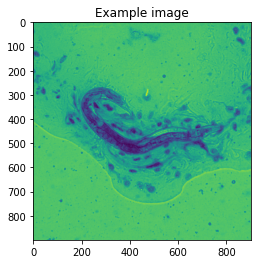

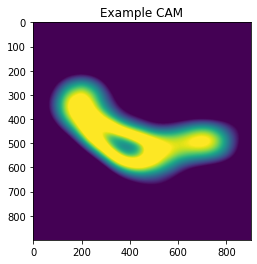

In [ ]:
#@title Load Long Lifespan Compute Overlap
# load measurements data
img_dir = os.path.join('/content/drive/My Drive/worm_models/lifespan/','test_images','3d','long')
pred_dir = os.path.join('/content/drive/My Drive/worm_models/lifespan/','test_images','3d','long-inference')
# load raw images
images = [f for f in os.listdir(img_dir) if f.endswith('.png')]



imgs = np.ndarray((len(images), img_rows, img_cols), dtype=np.float)
cams = np.ndarray((len(images), img_rows, img_cols), dtype=np.float)

for idx, img_name in enumerate(images):
        #print(idx)
        img = imread(os.path.join(img_dir, img_name), as_gray=True)
        #print(img.shape)
        #img = np.expand_dims(img, axis=-1)
        #print(img.shape)

        # load salincy plots
        cam = imread(os.path.join(pred_dir, img_name.replace('.png','_cam.tif')), as_gray=False, plugin='pil')
        cam = cam[:,:,0] # keep blue only - RGB [X,Y,Color]
        cam = np.rint(cam)
        #cam = np.expand_dims(cam, axis=-1)

        imgs[idx,:,:] = img.squeeze()
        cams[idx,:,:] = cam.squeeze()

imgs = np.expand_dims(imgs, axis=-1)
cams = np.expand_dims(cams, axis=-1)

n_imgs = test_imgs.shape[0]

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(imgs[80]))

plt.figure()
plt.title('Example CAM')
plt.imshow(np.squeeze(cams[80]))

small_imgs = resize(imgs, (n_imgs, target_width, target_height, 1))
small_cams = resize(cams, (n_imgs, target_width, target_height, 1))

test_image_datagen.fit(small_imgs, augment=False, seed=seed)
image_generator = test_image_datagen.flow(small_imgs, batch_size=n_imgs, seed=seed)


_bg_pred, tail_bg_pred , mid_bg_pred, head_bg_pred = model.predict(image_generator.next())

tail_cams = np.sum((1 - tail_bg_pred) * small_cams)
mid_cams = np.sum((1 - mid_bg_pred) * small_cams)
head_cams = np.sum((1 - head_bg_pred) * small_cams)

tail_cams_pct = tail_cams / (tail_cams + mid_cams + head_cams)
mid_cams_pct = mid_cams / (tail_cams + mid_cams + head_cams)
head_cams_pct = head_cams / (tail_cams + mid_cams + head_cams)
print(
    """
    Movement Class Activation Masks are:\
    \n in {}% cases looking at tail,
    \n in {}% cases looking at mid body,
    \n in {}% cases looking at head,
    """.format(tail_cams_pct, mid_cams_pct, head_cams_pct))

# Tally up for each image

tail_cams = np.sum((1 - tail_bg_pred) * small_cams, axis=(1,2,3))
mid_cams = np.sum((1 - mid_bg_pred) * small_cams, axis=(1,2,3))
head_cams = np.sum((1 - head_bg_pred) * small_cams, axis=(1,2,3))

tail_cams_pct = tail_cams / (tail_cams + mid_cams + head_cams)
mid_cams_pct = mid_cams / (tail_cams + mid_cams + head_cams)
head_cams_pct = head_cams / (tail_cams + mid_cams + head_cams)

import pandas as pd
results = pd.DataFrame({'tail_cams_pct':tail_cams_pct, 'mid_cams_pct':mid_cams_pct, 'head_cams_pct':head_cams_pct})

res_file = os.path.join('/content/drive/My Drive/worm_models/fine-segmentation/','Long_Lifespan_Overlap.csv')
results.to_csv(res_file)
results.head()


    Movement Class Activation Masks are:    
 in 0.3349604304396877% cases looking at tail,
    
 in 0.3381386875015892% cases looking at mid body,
    
 in 0.326900882058723% cases looking at head,
    


,tail_cams_pct,mid_cams_pct,head_cams_pct
0,0.341176,0.337249,0.321575
1,0.334299,0.334645,0.331056
2,0.326184,0.339158,0.334658
3,0.327761,0.326512,0.345727
4,0.350007,0.341843,0.308150


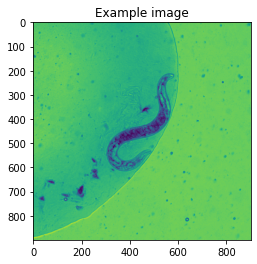

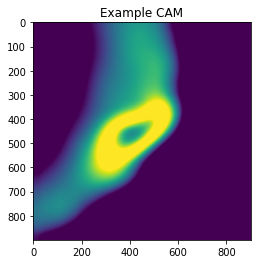

In [ ]:
#@title Load Short Lifespan Compute Overlap
# load measurements data
img_dir = os.path.join('/content/drive/My Drive/worm_models/lifespan/','test_images','3d','short')
pred_dir = os.path.join('/content/drive/My Drive/worm_models/lifespan/','test_images','3d','short-inference')
# load raw images
images = [f for f in os.listdir(img_dir) if f.endswith('.png')]



imgs = np.ndarray((len(images), img_rows, img_cols), dtype=np.float)
cams = np.ndarray((len(images), img_rows, img_cols), dtype=np.float)

for idx, img_name in enumerate(images):
        #print(idx)
        img = imread(os.path.join(img_dir, img_name), as_gray=True)
        #print(img.shape)
        #img = np.expand_dims(img, axis=-1)
        #print(img.shape)

        # load salincy plots
        cam = imread(os.path.join(pred_dir, img_name.replace('.png','_cam.tif')), as_gray=False, plugin='pil')
        cam = cam[:,:,0] # keep blue only - RGB [X,Y,Color]
        cam = np.rint(cam)
        #cam = np.expand_dims(cam, axis=-1)

        imgs[idx,:,:] = img.squeeze()
        cams[idx,:,:] = cam.squeeze()

imgs = np.expand_dims(imgs, axis=-1)
cams = np.expand_dims(cams, axis=-1)

n_imgs = test_imgs.shape[0]

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(imgs[80]))

plt.figure()
plt.title('Example CAM')
plt.imshow(np.squeeze(cams[80]))

small_imgs = resize(imgs, (n_imgs, target_width, target_height, 1))
small_cams = resize(cams, (n_imgs, target_width, target_height, 1))

test_image_datagen.fit(small_imgs, augment=False, seed=seed)
image_generator = test_image_datagen.flow(small_imgs, batch_size=n_imgs, seed=seed)


_bg_pred, tail_bg_pred , mid_bg_pred, head_bg_pred = model.predict(image_generator.next())

tail_cams = np.sum((1 - tail_bg_pred) * small_cams)
mid_cams = np.sum((1 - mid_bg_pred) * small_cams)
head_cams = np.sum((1 - head_bg_pred) * small_cams)

tail_cams_pct = tail_cams / (tail_cams + mid_cams + head_cams)
mid_cams_pct = mid_cams / (tail_cams + mid_cams + head_cams)
head_cams_pct = head_cams / (tail_cams + mid_cams + head_cams)
print(
    """
    Movement Class Activation Masks are:\
    \n in {}% cases looking at tail,
    \n in {}% cases looking at mid body,
    \n in {}% cases looking at head,
    """.format(tail_cams_pct, mid_cams_pct, head_cams_pct))

# Tally up for each image

tail_cams = np.sum((1 - tail_bg_pred) * small_cams, axis=(1,2,3))
mid_cams = np.sum((1 - mid_bg_pred) * small_cams, axis=(1,2,3))
head_cams = np.sum((1 - head_bg_pred) * small_cams, axis=(1,2,3))

tail_cams_pct = tail_cams / (tail_cams + mid_cams + head_cams)
mid_cams_pct = mid_cams / (tail_cams + mid_cams + head_cams)
head_cams_pct = head_cams / (tail_cams + mid_cams + head_cams)

import pandas as pd
results = pd.DataFrame({'tail_cams_pct':tail_cams_pct, 'mid_cams_pct':mid_cams_pct, 'head_cams_pct':head_cams_pct})

res_file = os.path.join('/content/drive/My Drive/worm_models/fine-segmentation/','Short_Lifespan_Overlap.csv')
results.to_csv(res_file)
results.head()